## LSTM Encoder-Decoder Anomaly Detection

Ключевое отличие от обычного LSTM-AE в том, что декодер, как и энкодер, имеет свои входы. В остальном это та же архитектура автоэнкодера со скрытыми LSTM слоями. Идея в том, что входы декодера на этапе обучения могут дополнительно корректировать выходы из энкодера. На этапе тестирования в декодер шаг за шагом подается его же предсказанный выход.

In [41]:
from models.lstm_ad import LSTM_AD
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score
from utils.data import create_sequences

from ipywidgets import IntProgress
from IPython.display import display

### Seed fixation

In [42]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [43]:
class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 10
    batch_size = 10
    Q = 0.99

In [44]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")

df.sort_index(inplace=True)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0


In [47]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [52]:
prediction = LSTM_AD_Predictor().make_prediction(df)

Epoch 1/10
53/53 [==============================] - 8s 81ms/step - loss: 0.7527
Epoch 2/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5462
Epoch 3/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4643
Epoch 4/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4595
Epoch 5/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4579
Epoch 6/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4575
Epoch 7/10
53/53 [==============================] - 5s 86ms/step - loss: 0.4572
Epoch 8/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4570
Epoch 9/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4569
Epoch 10/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4568


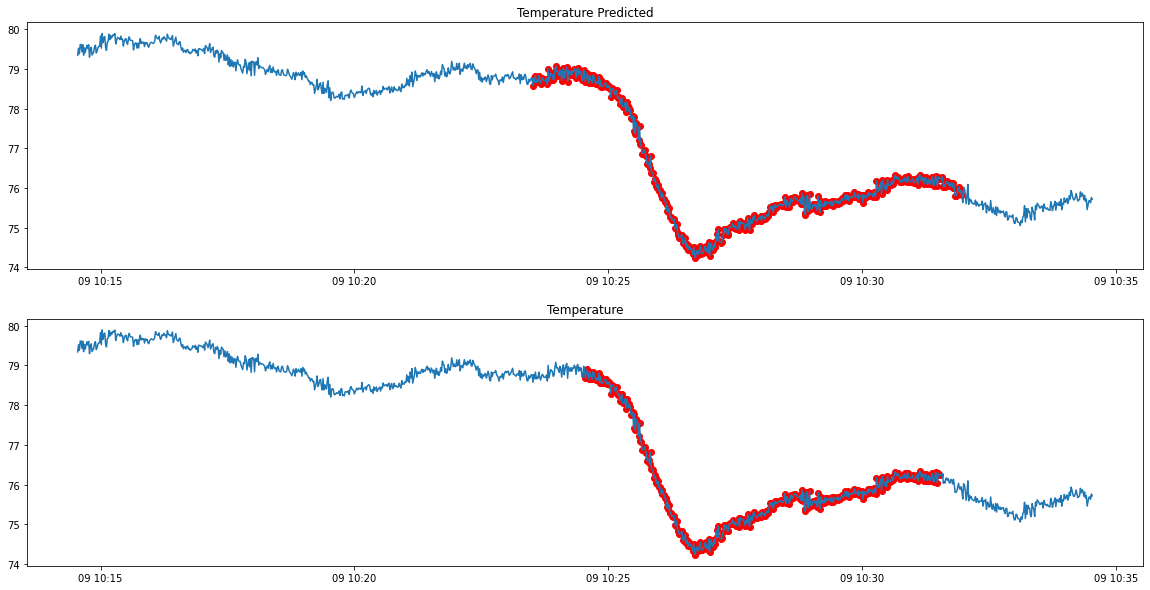

In [53]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(df.anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [54]:
print(f"""F1 = {f1_score(df.anomaly, prediction)}
FAR = {far(df.anomaly, prediction)}
MAR = {mar(df.anomaly, prediction)}""")

F1 = 0.9051918735891648
FAR = 0.1126005361930295
MAR = 0.0


### Применение метода ко всем датасетам

In [4]:
from utils.pipeline import Pipeline, Predictor

In [51]:
conf = Config

class LSTM_AD_Predictor(Predictor):
    def make_prediction(self, df):
        
        SS = StandardScaler()
        first_anomaly_idx = df.index.get_loc(df[df["anomaly"] == 1].index[0])
        df = df.drop(['anomaly','changepoint'], axis=1)
        conf.train_size = first_anomaly_idx
             
        x_train = np.array(SS.fit_transform(df[:conf.train_size]))
        x_train = create_sequences(x_train, conf.TIME_STEPS)

        lstm_ad = LSTM_AD().fit(x_train, epochs=conf.epochs, batch_size=conf.batch_size)
        x_test = np.array(SS.transform(df))
        x_test = create_sequences(x_test, conf.TIME_STEPS)

        predictions = lstm_ad.predict(x_test)

        r = pd.Series(np.sum(np.mean(np.abs(np.array(predictions) - x_test), axis=1), axis=1))
        health_r = r[:conf.train_size]
        
        UCL = health_r[: len(health_r) - conf.TIME_STEPS + 1].quantile(conf.Q)
        
        anomalous_data = r > UCL
        anomalous_data_indices = [] 
        for data_idx in range(conf.TIME_STEPS, len(x_test) - conf.TIME_STEPS + 1):
            if (anomalous_data[data_idx - conf.TIME_STEPS : data_idx]).astype(int).sum() >= conf.TIME_STEPS * 0.8:
                anomalous_data_indices.append(data_idx - conf.TIME_STEPS)
        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction

Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 9s 71ms/step - loss: 0.7728
Epoch 2/10
53/53 [==============================] - 5s 94ms/step - loss: 0.5574
Epoch 3/10
53/53 [==============================] - 5s 94ms/step - loss: 0.4756
Epoch 4/10
53/53 [==============================] - 5s 95ms/step - loss: 0.4718
Epoch 5/10
53/53 [==============================] - 5s 99ms/step - loss: 0.4701
Epoch 6/10
53/53 [==============================] - 5s 100ms/step - loss: 0.4690
Epoch 7/10
53/53 [==============================] - 5s 85ms/step - loss: 0.4684
Epoch 8/10
53/53 [==============================] - 4s 81ms/step - loss: 0.4681
Epoch 9/10
53/53 [==============================] - 5s 83ms/step - loss: 0.4679
Epoch 10/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4678
Epoch 1/10
53/53 [==============================] - 9s 87ms/step - loss: 0.7591
Epoch 2/10
53/53 [==============================] - 4s 83ms/step - loss: 0.5762
Epoch 3/10
53/53 [====================

53/53 [==============================] - 5s 88ms/step - loss: 0.4528
Epoch 4/10
53/53 [==============================] - 4s 82ms/step - loss: 0.4498
Epoch 5/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4485
Epoch 6/10
53/53 [==============================] - 5s 86ms/step - loss: 0.4478
Epoch 7/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4474
Epoch 8/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4470
Epoch 9/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4467
Epoch 10/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4466
Epoch 1/10
52/52 [==============================] - 7s 72ms/step - loss: 0.7733
Epoch 2/10
52/52 [==============================] - 4s 72ms/step - loss: 0.5592
Epoch 3/10
52/52 [==============================] - 4s 72ms/step - loss: 0.4950
Epoch 4/10
52/52 [==============================] - 4s 74ms/step - loss: 0.4918
Epoch 5/10
52/52 [==============================] 

IntProgress(value=0, description='Computing', max=4, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 8s 78ms/step - loss: 0.7965
Epoch 2/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5872
Epoch 3/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5076
Epoch 4/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5047
Epoch 5/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5036
Epoch 6/10
52/52 [==============================] - 4s 78ms/step - loss: 0.5030
Epoch 7/10
52/52 [==============================] - 4s 78ms/step - loss: 0.5026
Epoch 8/10
52/52 [==============================] - 4s 80ms/step - loss: 0.5024
Epoch 9/10
52/52 [==============================] - 4s 83ms/step - loss: 0.5023
Epoch 10/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5022
Epoch 1/10
52/52 [==============================] - 8s 79ms/step - loss: 0.8076
Epoch 2/10
52/52 [==============================] - 4s 78ms/step - loss: 0.5837
Epoch 3/10
52/52 [=====================

IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 79ms/step - loss: 0.7751
Epoch 2/10
53/53 [==============================] - 4s 78ms/step - loss: 0.5572
Epoch 3/10
53/53 [==============================] - 4s 78ms/step - loss: 0.4897
Epoch 4/10
53/53 [==============================] - 4s 78ms/step - loss: 0.4852
Epoch 5/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4846
Epoch 6/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4843
Epoch 7/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4842
Epoch 8/10
53/53 [==============================] - 4s 78ms/step - loss: 0.4841
Epoch 9/10
53/53 [==============================] - 4s 82ms/step - loss: 0.4841
Epoch 10/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4840
F1 = 0.9251282051282051

FAR = 0.09878213802435724

MAR = 0.0

Anomaly: other1


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 79ms/step - loss: 0.7324
Epoch 2/10
53/53 [==============================] - 4s 78ms/step - loss: 0.5372
Epoch 3/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4714
Epoch 4/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4662
Epoch 5/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4646
Epoch 6/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4643
Epoch 7/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4640
Epoch 8/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4638
Epoch 9/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4637
Epoch 10/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4637
F1 = 0.9011235955056179

FAR = 0.11843876177658143

MAR = 0.0

Anomaly: other2


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 81ms/step - loss: 0.8037
Epoch 2/10
53/53 [==============================] - 4s 79ms/step - loss: 0.6410
Epoch 3/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5757
Epoch 4/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5692
Epoch 5/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5678
Epoch 6/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5674
Epoch 7/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5672
Epoch 8/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5671
Epoch 9/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5670
Epoch 10/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5670
F1 = 0.9070796460176991

FAR = 0.11275167785234899

MAR = 0.0

Anomaly: other3


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 9s 92ms/step - loss: 0.7608
Epoch 2/10
52/52 [==============================] - 4s 81ms/step - loss: 0.5814
Epoch 3/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5044
Epoch 4/10
52/52 [==============================] - 4s 79ms/step - loss: 0.4943
Epoch 5/10
52/52 [==============================] - 4s 80ms/step - loss: 0.4924
Epoch 6/10
52/52 [==============================] - 4s 79ms/step - loss: 0.4916
Epoch 7/10
52/52 [==============================] - 4s 79ms/step - loss: 0.4914
Epoch 8/10
52/52 [==============================] - 4s 79ms/step - loss: 0.4913
Epoch 9/10
52/52 [==============================] - 4s 79ms/step - loss: 0.4912
Epoch 10/10
52/52 [==============================] - 4s 80ms/step - loss: 0.4912
F1 = 0.8753541076487252

FAR = 0.11907983761840325

MAR = 0.0

Anomaly: other4


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
45/45 [==============================] - 7s 81ms/step - loss: 0.7510
Epoch 2/10
45/45 [==============================] - 4s 79ms/step - loss: 0.6169
Epoch 3/10
45/45 [==============================] - 4s 79ms/step - loss: 0.5360
Epoch 4/10
45/45 [==============================] - 4s 79ms/step - loss: 0.5092
Epoch 5/10
45/45 [==============================] - 4s 79ms/step - loss: 0.5041
Epoch 6/10
45/45 [==============================] - 4s 80ms/step - loss: 0.5029
Epoch 7/10
45/45 [==============================] - 4s 78ms/step - loss: 0.5028
Epoch 8/10
45/45 [==============================] - 4s 78ms/step - loss: 0.5018
Epoch 9/10
45/45 [==============================] - 4s 79ms/step - loss: 0.5013
Epoch 10/10
45/45 [==============================] - 4s 79ms/step - loss: 0.5011
F1 = 0.7302325581395349

FAR = 0.0121580547112462

MAR = 0.4075471698113208

Anomaly: other5


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 8s 79ms/step - loss: 0.8096
Epoch 2/10
52/52 [==============================] - 4s 79ms/step - loss: 0.6044
Epoch 3/10
52/52 [==============================] - 4s 80ms/step - loss: 0.5278
Epoch 4/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5201
Epoch 5/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5178
Epoch 6/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5167
Epoch 7/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5160
Epoch 8/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5156
Epoch 9/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5154
Epoch 10/10
52/52 [==============================] - 4s 79ms/step - loss: 0.5153
F1 = 0.9051282051282051

FAR = 0.03924221921515562

MAR = 0.11306532663316583

Anomaly: other6


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
51/51 [==============================] - 9s 79ms/step - loss: 0.7732
Epoch 2/10
51/51 [==============================] - 4s 80ms/step - loss: 0.6114
Epoch 3/10
51/51 [==============================] - 4s 79ms/step - loss: 0.5146
Epoch 4/10
51/51 [==============================] - 4s 81ms/step - loss: 0.5074
Epoch 5/10
51/51 [==============================] - 4s 79ms/step - loss: 0.5052
Epoch 6/10
51/51 [==============================] - 4s 82ms/step - loss: 0.5038
Epoch 7/10
51/51 [==============================] - 4s 80ms/step - loss: 0.5029
Epoch 8/10
51/51 [==============================] - 4s 88ms/step - loss: 0.5024
Epoch 9/10
51/51 [==============================] - 4s 80ms/step - loss: 0.5021
Epoch 10/10
51/51 [==============================] - 4s 80ms/step - loss: 0.5019
F1 = 0.27303754266211605

FAR = 0.11669658886894076

MAR = 0.7872340425531915

Anomaly: other7


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 82ms/step - loss: 0.8006
Epoch 2/10
53/53 [==============================] - 4s 84ms/step - loss: 0.5958
Epoch 3/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5367
Epoch 4/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5319
Epoch 5/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5312
Epoch 6/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5309
Epoch 7/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5307
Epoch 8/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5306
Epoch 9/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5305
Epoch 10/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5305
F1 = 0.8635724331926864

FAR = 0.07671601615074024

MAR = 0.11527377521613832

Anomaly: other8


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 79ms/step - loss: 0.7710
Epoch 2/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5803
Epoch 3/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5084
Epoch 4/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5026
Epoch 5/10
53/53 [==============================] - 4s 78ms/step - loss: 0.5017
Epoch 6/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5013
Epoch 7/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5012
Epoch 8/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5013
Epoch 9/10
53/53 [==============================] - 4s 78ms/step - loss: 0.5010
Epoch 10/10
53/53 [==============================] - 4s 78ms/step - loss: 0.5010
F1 = 0.9766666666666667

FAR = 0.037786774628879895

MAR = 0.0

Anomaly: other9


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 83ms/step - loss: 0.8011
Epoch 2/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5718
Epoch 3/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5266
Epoch 4/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5237
Epoch 5/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5231
Epoch 6/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5228
Epoch 7/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5230
Epoch 8/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5225
Epoch 9/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5223
Epoch 10/10
53/53 [==============================] - 4s 80ms/step - loss: 0.5223
F1 = 0.7045454545454546

FAR = 0.06633499170812604

MAR = 0.3841059602649007

Anomaly: other10


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
75/75 [==============================] - 10s 80ms/step - loss: 0.7302
Epoch 2/10
75/75 [==============================] - 6s 82ms/step - loss: 0.5263
Epoch 3/10
75/75 [==============================] - 6s 83ms/step - loss: 0.5037
Epoch 4/10
75/75 [==============================] - 6s 80ms/step - loss: 0.5016
Epoch 5/10
75/75 [==============================] - 6s 80ms/step - loss: 0.5007
Epoch 6/10
75/75 [==============================] - 6s 80ms/step - loss: 0.5002
Epoch 7/10
75/75 [==============================] - 6s 80ms/step - loss: 0.4999
Epoch 8/10
75/75 [==============================] - 6s 80ms/step - loss: 0.4998
Epoch 9/10
75/75 [==============================] - 6s 80ms/step - loss: 0.4997
Epoch 10/10
75/75 [==============================] - 6s 80ms/step - loss: 0.4997
F1 = 0.736

FAR = 0.0

MAR = 0.4177215189873418

Anomaly: other11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 9s 79ms/step - loss: 0.7976
Epoch 2/10
53/53 [==============================] - 4s 78ms/step - loss: 0.5745
Epoch 3/10
53/53 [==============================] - 4s 79ms/step - loss: 0.5014
Epoch 4/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4988
Epoch 5/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4981
Epoch 6/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4978
Epoch 7/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4976
Epoch 8/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4975
Epoch 9/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4974
Epoch 10/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4973
F1 = 0.90744920993228

FAR = 0.11006711409395974

MAR = 0.0

Anomaly: other12


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 84ms/step - loss: 0.7528
Epoch 2/10
53/53 [==============================] - 4s 81ms/step - loss: 0.5696
Epoch 3/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4926
Epoch 4/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4850
Epoch 5/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4835
Epoch 6/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4830
Epoch 7/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4828
Epoch 8/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4826
Epoch 9/10
53/53 [==============================] - 4s 79ms/step - loss: 0.4825
Epoch 10/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4825
F1 = 0.48796147672552165

FAR = 0.0913978494623656

MAR = 0.6228287841191067

Anomaly: other13


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
6/6 [==============================] - 4s 81ms/step - loss: 0.9212
Epoch 2/10
6/6 [==============================] - 1s 79ms/step - loss: 0.8748
Epoch 3/10
6/6 [==============================] - 1s 90ms/step - loss: 0.8177
Epoch 4/10
6/6 [==============================] - 1s 80ms/step - loss: 0.7800
Epoch 5/10
6/6 [==============================] - 1s 81ms/step - loss: 0.7545
Epoch 6/10
6/6 [==============================] - 1s 83ms/step - loss: 0.7290
Epoch 7/10
6/6 [==============================] - 1s 85ms/step - loss: 0.7030
Epoch 8/10
6/6 [==============================] - 1s 81ms/step - loss: 0.6687
Epoch 9/10
6/6 [==============================] - 1s 81ms/step - loss: 0.6224
Epoch 10/10
6/6 [==============================] - 1s 81ms/step - loss: 0.5744
F1 = 0.7901234567901234

FAR = 0.5151515151515151

MAR = 0.0

CPU times: user 1h 51min 12s, sys: 5min 18s, total: 1h 56min 31s
Wall time: 1h 5min 34s


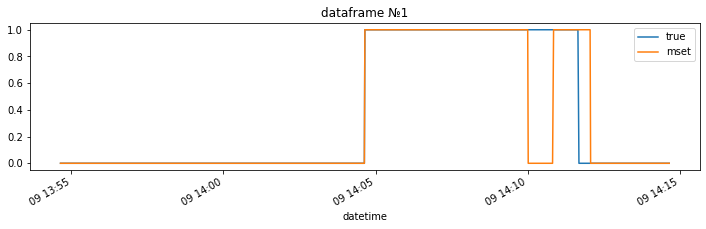

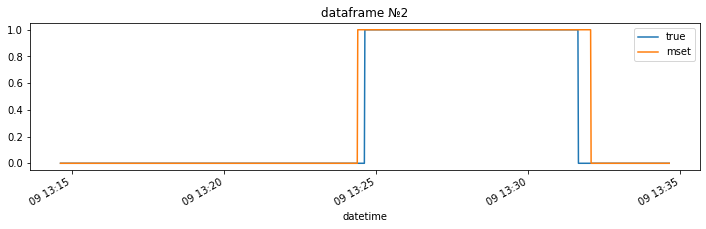

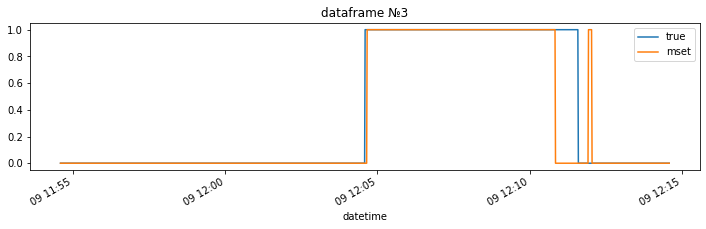

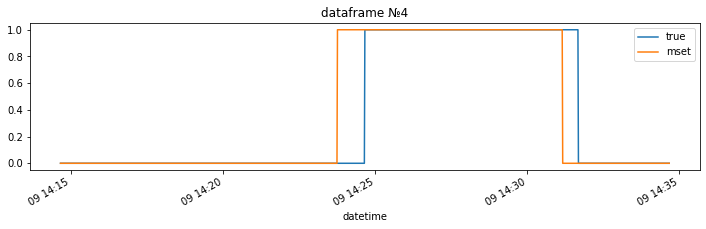

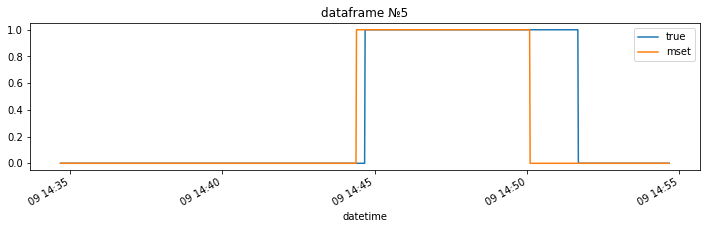

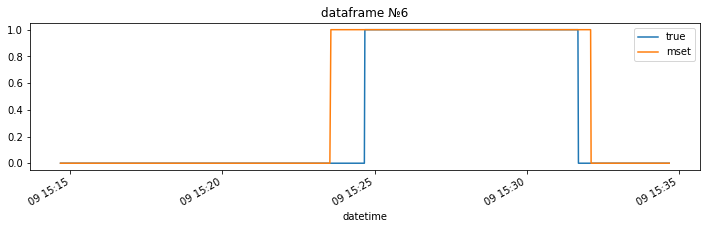

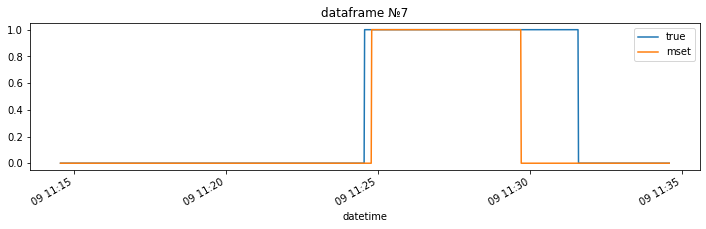

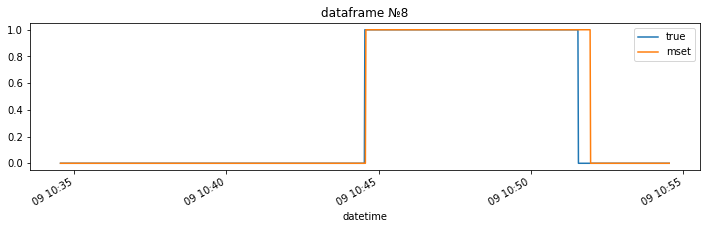

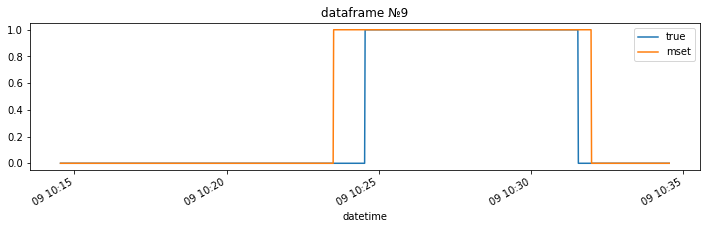

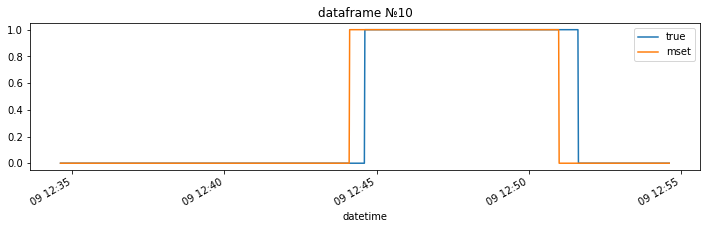

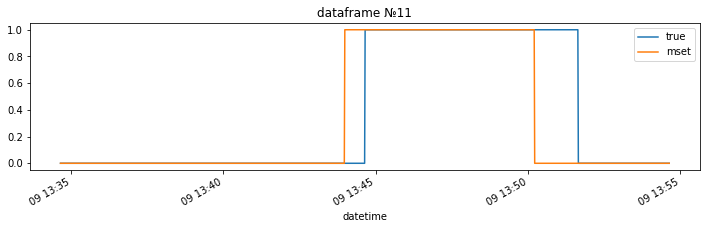

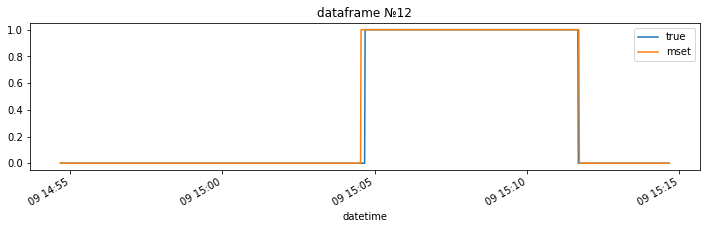

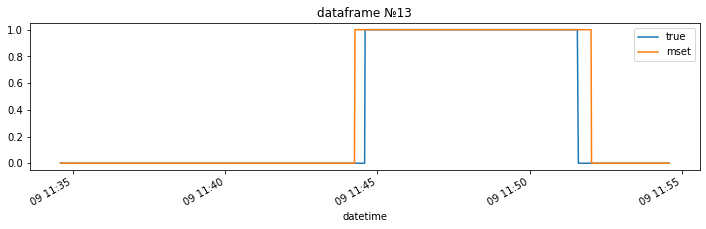

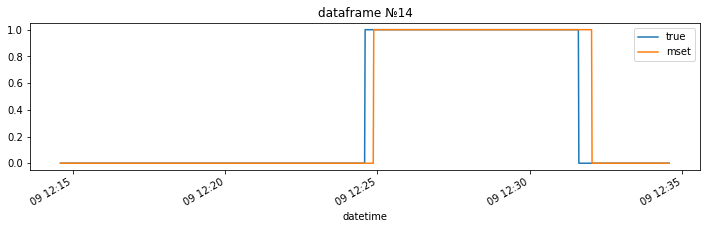

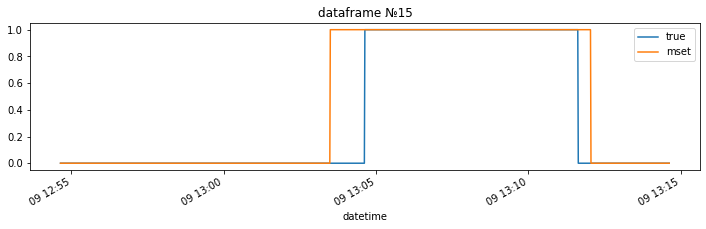

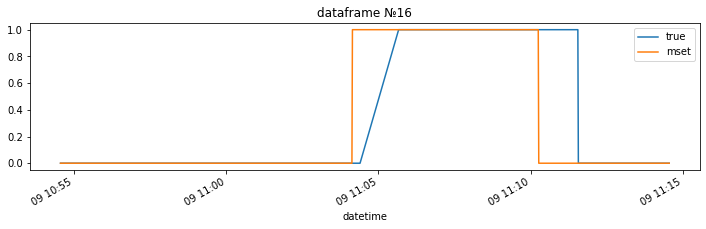

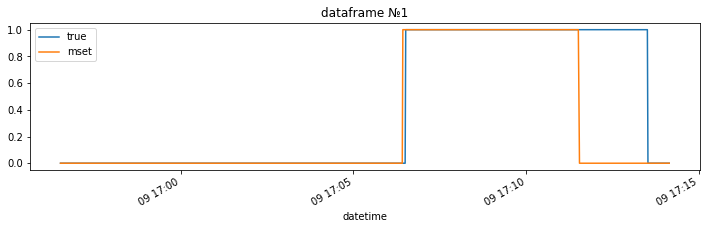

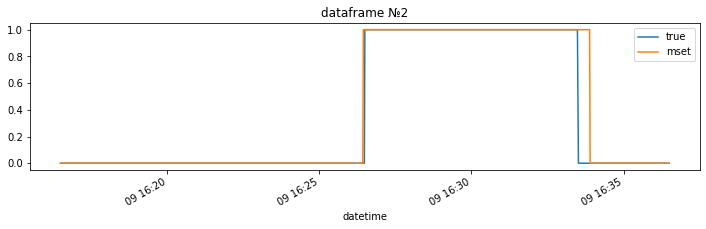

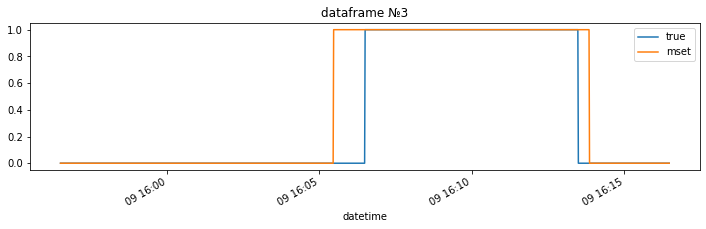

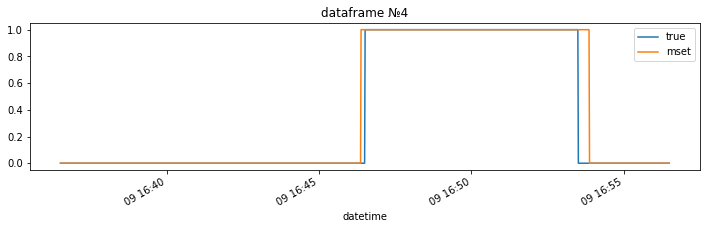

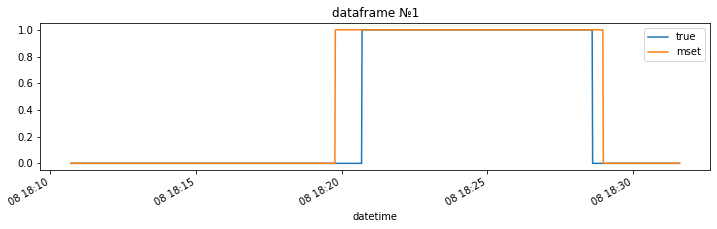

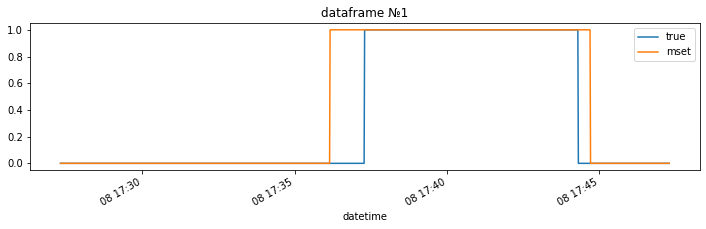

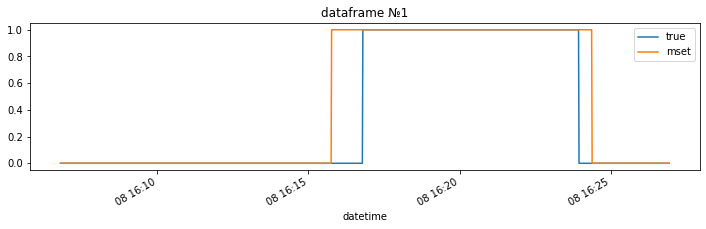

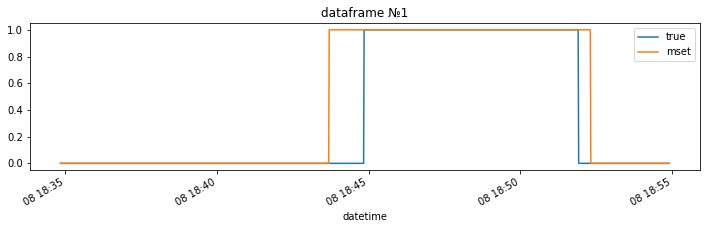

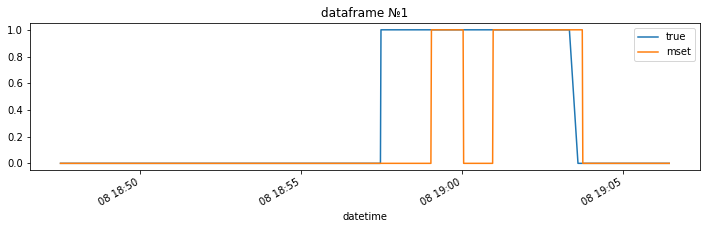

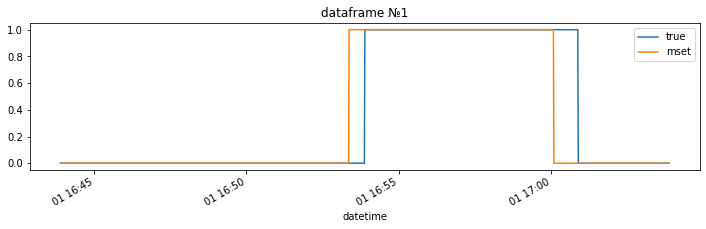

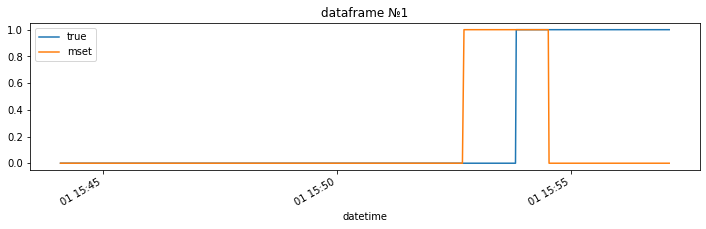

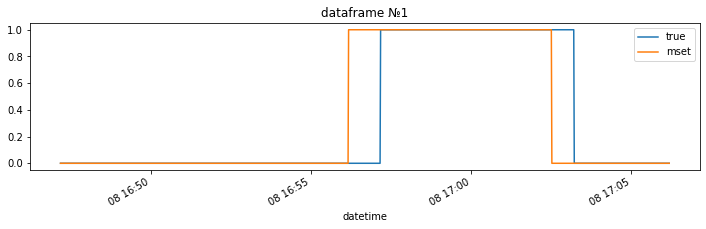

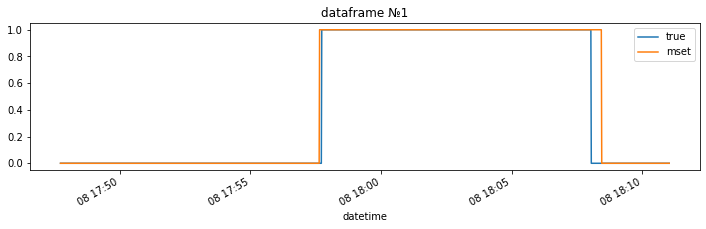

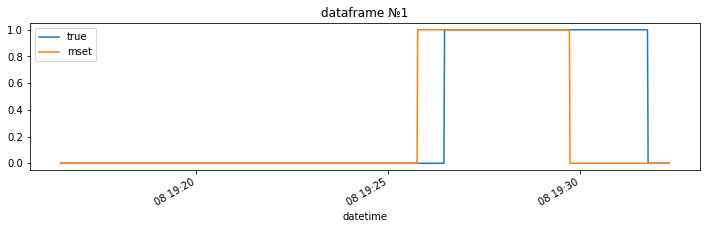

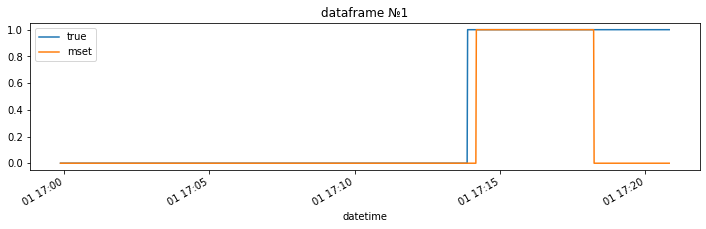

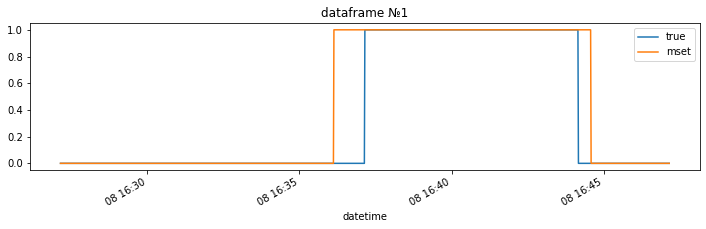

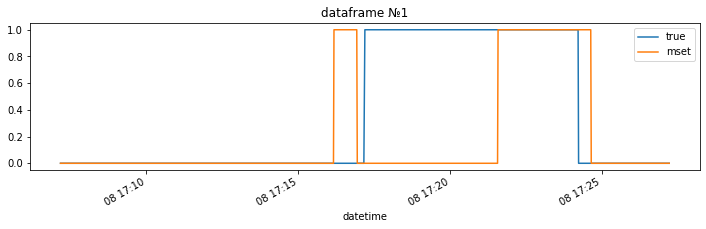

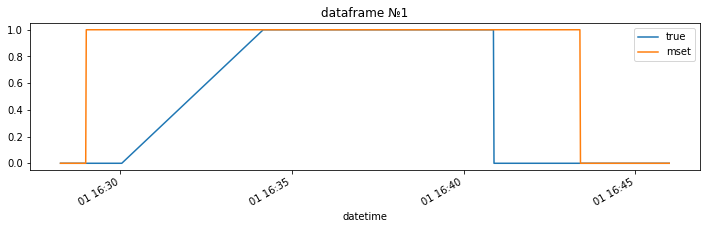

In [56]:
%%time
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", )
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

lstm_ad_predictor = LSTM_AD_Predictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, lstm_ad_predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [58]:
from utils.metrics import f1_score, far, mar

pred_outlier = pd.concat([pd.concat(p.all_predictions[i]) 
                          for i in range(len(p.all_predictions))])

list_of_all_df = []
for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            list_of_all_df.append(pd.concat([df.anomaly for df in [df, ]]))
    else:
        list_of_all_df.append(pd.concat([df.anomaly for df in list_of_df]))

true_outlier = pd.concat(list_of_all_df)

f1 = f1_score(true_outlier, pred_outlier)
far_score = far(true_outlier, pred_outlier)
mar_score = mar(true_outlier, pred_outlier)

metrics["all"] = (f1, far_score, mar_score)

In [59]:
from utils.data import show_score_table

show_score_table(metrics)

metric | valve1 | valve2 | other0 | other1 | other2 | other3 | other4 | other5 | other6 | other7 | other8 | other9 | other10 | other11 | other12 | other13 | all
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.91 | 0.92 | 0.93 | 0.9 | 0.91 | 0.88 | 0.73 | 0.91 | 0.27 | 0.86 | 0.98 | 0.7 | 0.74 | 0.91 | 0.49 | 0.79 | 0.88
FAR |0.05 | 0.05 | 0.1 | 0.12 | 0.11 | 0.12 | 0.01 | 0.04 | 0.12 | 0.08 | 0.04 | 0.07 | 0.0 | 0.11 | 0.09 | 0.52 | 0.07
MAR |0.09 | 0.07 | 0.0 | 0.0 | 0.0 | 0.0 | 0.41 | 0.11 | 0.79 | 0.12 | 0.0 | 0.38 | 0.42 | 0.0 | 0.62 | 0.0 | 0.12